#Convolutional neural network

###import library

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from glob import glob
#Le module glob recherche tous les chemins correspondant à un motif 
#particulier selon les règles utilisées par le shell Unix, les résultats sont renvoyés dans un ordre arbitraire.

import librosa
import librosa.display
import IPython.display as ipd

from tqdm import tqdm
import os

###Création mel spectrogramme pour chaque fichier audio

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
feature_list = []
label_list = []
dictMel = {}
# Iterate over all files in given source path
print('Preparing feature dataset and labels.')
for file in tqdm(os.listdir('/content/drive/MyDrive/projet supervised learning on your own/supervised learning on your own/AudioWAV')):
    # Skip if it's not a wav file
    if not file.endswith('.wav'):
        continue
    # Load audio and stretch it to length 1s
    audio_path = os.path.join('/content/drive/MyDrive/projet supervised learning on your own/supervised learning on your own/AudioWAV', file)
    audio, sr = librosa.load(path=audio_path, sr=None)
    audio = librosa.effects.time_stretch(y=audio, rate=len(audio)/sr)
    # Calculate features and get the label from the filename
    mels = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=512)
    mels_db = librosa.power_to_db(S=mels, ref=1.0)
    if mels_db.shape == (128,32):
      feature_list.append(mels_db.reshape((128, 32, 1)))
      filename = str(file)[:-4]
      label_list.append(filename)
      dictMel[filename] = mels_db
features = np.array(feature_list)
labels = np.array(label_list)

Preparing feature dataset and labels.


100%|██████████| 7447/7447 [02:30<00:00, 49.39it/s]


In [16]:
features.shape

(7447, 128, 32, 1)

In [17]:
labels.shape

(7447,)

###Tri des élements par ordre de nom de fichier

In [34]:
dataMel = pd.Series(dictMel)
dataMel=dataMel.sort_index()
listMel =dataMel.to_list()
liste_son=dataMel.index.to_list()

###On converti en matrice 3D

In [37]:
def list_to_matrix(X):
  matrix = np.zeros(shape=(len(X),128, 32))
  for i in range(len(X)):
    if X[i].shape == (128, 32):
      #print(X[i].shape, ' son num : ',i)
      matrix[i]=X[i]
  return matrix

matrix = list_to_matrix(listMel)

In [39]:
matrix[0]

array([[-41.02635193, -34.52111816, -33.46742249, ..., -37.52510452,
        -34.50287628, -31.78588486],
       [-35.16249847, -29.44963646, -28.84917259, ..., -28.70441246,
        -28.17249107, -28.09036446],
       [-30.01316261, -24.35401917, -22.41397667, ..., -18.86247253,
        -20.06266785, -21.37977982],
       ...,
       [-61.41165924, -54.73984146, -53.39689255, ..., -57.22369766,
        -57.89124298, -59.00911713],
       [-62.87792206, -56.04319763, -54.13166809, ..., -55.05571747,
        -54.91855621, -58.64489746],
       [-62.52461243, -55.07435226, -53.67029572, ..., -56.17289734,
        -55.75691986, -58.09585571]])

###Récupération des labels

In [20]:
crema_directory_list = os.listdir('/content/drive/MyDrive/projet supervised learning on your own/supervised learning on your own/AudioWAV')

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,disgust,1079_TSI_DIS_XX.wav
1,fear,1079_TIE_FEA_XX.wav
2,disgust,1080_DFA_DIS_XX.wav
3,disgust,1079_TIE_DIS_XX.wav
4,neutral,1079_TIE_NEU_XX.wav


In [21]:
Crema_df = Crema_df.sort_values(by=['Path'], ascending=True)

In [22]:
Crema_df.reset_index(drop=True)

,Emotions,Path
0,angry,1001_DFA_ANG_XX.wav
1,disgust,1001_DFA_DIS_XX.wav
2,fear,1001_DFA_FEA_XX.wav
3,happy,1001_DFA_HAP_XX.wav
4,neutral,1001_DFA_NEU_XX.wav
...,...,...
7442,disgust,1091_WSI_DIS_XX.wav
7443,fear,1091_WSI_FEA_XX.wav
7444,happy,1091_WSI_HAP_XX.wav
7445,neutral,1091_WSI_NEU_XX.wav


On crée la target 

### Préparation des données pour le réseau de neuronnes

In [24]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [40]:
X_train_full = matrix
y_train_full = le.fit_transform(Crema_df.Emotions)

In [47]:
X_train_full.max(1)

array([[-26.32200241, -14.35773277,  -9.8089695 , ..., -10.65508747,
         -9.89501953, -10.1158905 ],
       [ -9.94677448, -11.50812912, -10.03906059, ..., -13.05936241,
        -12.94575214, -15.89485645],
       [ -7.47916222, -10.41435719,  -9.58856964, ...,  -9.15598679,
        -12.26987743, -15.91882706],
       ...,
       [ -8.46858788, -12.35991573, -12.62092686, ..., -14.14100742,
        -13.78639698, -16.53601456],
       [-10.57913971, -12.37317848, -10.89770412, ..., -15.47972202,
        -13.85290623, -13.74810219],
       [ -9.583601  , -11.29083252, -11.47842026, ..., -15.07207489,
        -15.15394402, -13.16065311]])

###Constuire un model avec tf.keras.sequential

In [26]:
import tensorflow as tf
from tensorflow import keras

In [27]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [42]:
model = keras.Sequential(layers=[
        keras.layers.InputLayer(input_shape=features[0].shape),
        keras.layers.Conv2D(16, 3, padding='same', activation=keras.activations.relu),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(32, 3, padding='same', activation=keras.activations.relu),
        keras.layers.MaxPooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dense(6, activation=keras.activations.softmax)
    ])
model.compile(optimizer=keras.optimizers.Adam(), loss="sparse_categorical_crossentropy", metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 128, 32, 16)       160       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 16, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 8, 32)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_1 (Dropout)         (None, 8192)             

Epoch 1/20
239/239 [==============================] - 14s 57ms/step - loss: 2.6570 - accuracy: 0.3314 - val_loss: 1.4887 - val_accuracy: 0.3678
Epoch 2/20
239/239 [==============================] - 13s 55ms/step - loss: 1.3891 - accuracy: 0.4459 - val_loss: 1.3913 - val_accuracy: 0.4336
Epoch 3/20
239/239 [==============================] - 13s 55ms/step - loss: 1.3101 - accuracy: 0.4796 - val_loss: 1.3980 - val_accuracy: 0.4262
Epoch 4/20
239/239 [==============================] - 14s 57ms/step - loss: 1.2627 - accuracy: 0.5044 - val_loss: 1.4699 - val_accuracy: 0.4450
Epoch 5/20
239/239 [==============================] - 14s 57ms/step - loss: 1.2107 - accuracy: 0.5209 - val_loss: 1.3850 - val_accuracy: 0.4624
Epoch 6/20
239/239 [==============================] - 13s 56ms/step - loss: 1.1781 - accuracy: 0.5390 - val_loss: 1.3989 - val_accuracy: 0.4503
Epoch 7/20
239/239 [==============================] - 13s 55ms/step - loss: 1.1279 - accuracy: 0.5572 - val_loss: 1.3183 - val_accuracy:

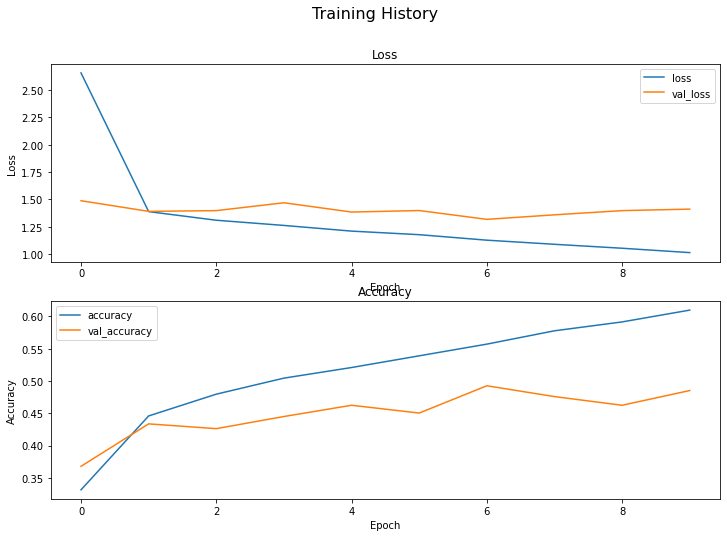

In [43]:
# Set parameters for data splitting and training
TEST_SIZE = 0.2
BATCH_SIZE = 25
EPOCHS = 20

# Encode Labels
#encoded_labels = tf.one_hot(indices=labels, depth=10)
# Split dataset to train and test data
#X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels.numpy(), test_size=TEST_SIZE)

# Train the model
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(x=X_train_full, y=y_train_full, validation_split=TEST_SIZE, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping])

# Plot the training history
fig, axs = plt.subplots(2)
fig.set_size_inches(12, 8)
fig.suptitle('Training History', fontsize=16)
axs[0].plot(history.epoch, history.history['loss'], history.history['val_loss'])
axs[0].set(title='Loss', xlabel='Epoch', ylabel='Loss')
axs[0].legend(['loss', 'val_loss'])
axs[1].plot(history.epoch, history.history['accuracy'], history.history['val_accuracy'])
axs[1].set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')
axs[1].legend(['accuracy', 'val_accuracy'])
plt.show()